<a href="https://colab.research.google.com/github/juankuntz/ParEM/blob/main/jax/bayesian_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Description:** This notebook demonstrates the application of PGD, PQN, PMGD, SOUL, and VI to the Bayesian latent space network model from Hoff et al. (2002). 

# Latent space network model - Sampson Monks Data

First, we load the modules that we will need:

In [1]:
#@title Load modules.

# Install the wget package on Colab (if running the notebook locally,
# comment the following line out).
#!pip install wget

# OS and wget to load dataset.
import os
from scipy.stats import norm
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import procrustes

# Numpy for computations.
import numpy as np
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

key = random.PRNGKey(0)

# Pyplot for plots.
import matplotlib.pyplot as plt 

In [2]:
from load_monks import load_monks

# Load Sampson's monastery network
Y, labels, names = load_monks(dynamic=True, is_directed=False)
y=jnp.asarray(Y[0])

In [1]:
#log-target density p_theta(y,x)
def log_target(th, z):

    

    dist = jnp.matmul(z,z.T)/jnp.linalg.norm(z,axis=1)
    #dist = jnp.sqrt(jnp.sum((z[None, :] - z[:, None])**2, -1))
    eta = th - dist
    log_prior =  -jnp.sum(jnp.dot(z.T,z))  
    log_lik = jnp.sum(jnp.multiply(y,eta) - jnp.log1p(jnp.exp(eta)))
    return log_lik + log_prior

#def log_target(th, z):
#    #dist = jnp.matmul(z,z.T)/jnp.linalg.norm(z,axis=1)
#    dist = (jnp.sqrt(jnp.sum((z[None, :] - z[:, None])**2, -1))).flatten()
#    eta = th - dist
#    log_prior =  -jnp.sum(jnp.dot(z.T,z))  
#    log_lik = jnp.sum(y.flatten()*eta - jnp.log1p(jnp.exp(eta)))
#    return log_lik + log_prior


Next, we load and curate the dataset:

In [4]:
# Sampson monk data

#y = np.asarray([[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
#[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
#[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
#[0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
#[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
#[1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
#[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
#[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
#[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
#[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
#[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
#[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0],
#[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
#[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
#[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])



We then implement the algorithms. They take the following inputs:

*   y : n x n adjacency matrix,
*   Z : n x D latent positions
*   K : number of steps,
*   N : number of particles,
*   th : 1-dimensional vector with parameter guess,
*   X : D x N matrix storing the initial particle cloud.

They return the following outputs:

*   th : K-dimensional vector of parameter estimates,
*   X : D x (KN) matrix storing the particle clouds (the kth cloud is X[:, (k-1)$^\ast$N : k$^\ast$N]).

In [5]:
#@title Implement algorithms

# Algorithms.

def vi(l, f, h, K, N, th, X, mu=None):
  D = f[0, :].size  # Extract latent variable dimension.
  mu = np.zeros(D) if mu is None else mu
  z = np.ones(D)
  for k in range(K):
    # update q
    def loss(mu, z):
      s2 = softplus(z)
      x = (np.random.normal(0, 1, (N, D)) * s2 ** 0.5  + mu).T
      log_prior =  - np.sum((x - th[k]) ** 2, 0) / 5  # Shape (N)
      log_likel =  l * np.matmul(f, x) - np.log(1 + np.exp(np.matmul(f, x)))  # (M, N)
      log_prob = np.sum(log_likel, 0)
      entropy = 0.5 * np.sum(np.log(s2))
      return np.mean(log_prob + log_prior, 0) + entropy
    step_size = h
    mu, z = mu + step_size * grad(loss, 0)(mu, z), z + step_size * grad(loss, 1)(mu, z)
    s2 = softplus(z)
    Xk = (np.random.normal(0, 1, (N, D)) * s2 ** 0.5 + mu).T
    # update theta
    th = np.append(th, th[k] + h*ave_grad_th(th[k], Xk))
    X = np.append(X, Xk, axis=1) # Store updated cloud.
  return th, X, mu, softplus(z)


def pgd(y, h, K, N, th, X):
    D = X[:,:,0].shape  # Extract latent variable dimension.
    Xkp1 = np.copy(X)
    
    for k in range(K):
        #Update particle cloud:
        gx = [grad_x(th[k],X[:,:,i]) for i in range(N)]
        for i in range(N):
            Xkp1[:,:,i] =  X[:,:,i] + h*gx[i] + np.sqrt(2*h)*np.random.normal(0, 1, D)

        #Procrustes transformation
        Xnew = np.copy(X)
        for i in range(N):
            _, Xnew[:,:,i], _ = procrustes(X[:,:,i], Xkp1[:,:,i])
    
        X = Xnew
        
        th = np.append(th, th[k] + h*np.mean([grad_alpha(th[k],X[:,:,i]) for i in range(N)]))  # Update theta.
    return th, X

#Coin version of the PGD function
def coin(y, K, N, th, X):
    theta0 = np.copy(th)
    x_shape = X.shape
    X0 = X.reshape(-1,X.shape[-1])

    # initialise other vars for X and theta
    L_theta, L_X = 0, 0
    grad_theta_sum, grad_Xk_sum = 0, 0
    reward_theta, reward_X = 0, 0
    abs_grad_theta_sum, abs_grad_Xk_sum = 0, 0
    for k in range(K):
        Xk = X.reshape(-1,X.shape[-1])  # Extract current particle cloud.
        # Update particle cloud:
        
        # calculate kernel matrix
        kxy, dx_kxy = svgd_kernel(Xk, h=-1)

        # gradient
        gx = [grad_x(th[k],X[:,:,i]).flatten() for i in range(N)]
        grad_Xk = (np.matmul(kxy, np.asarray(gx).T) + dx_kxy) 

        # |gradient|
        abs_grad_Xk = abs(grad_Xk)

        # constant
        L_X = np.maximum(abs_grad_Xk, L_X)

        # sum of gradients
        grad_Xk_sum += grad_Xk
        abs_grad_Xk_sum += abs_grad_Xk

        # 'reward'
        reward_X = np.maximum(reward_X + np.multiply(Xk - X0, grad_Xk), 0)

        # X update
        Xkp1 = X0 + grad_Xk_sum / (L_X * (abs_grad_Xk_sum + L_X)) * (L_X + reward_X)
        
        Xkp1 = Xkp1.reshape(x_shape)
        
        Xnew = np.zeros(x_shape)
        #Procrustes transformation
        for i in range(N):
            _, Xnew[:,:,i], _ = procrustes(X[:,:,i], Xkp1[:,:,i])
    
        
        X = jnp.copy(Xnew)
        
        # Update theta:
        # gradient
        grad_theta = np.mean([grad_alpha(th[k],X[:,:,i]) for i in range(N)]) 

        # |gradient|
        abs_grad_theta = abs(grad_theta)

        # constant
        L_theta = np.maximum(abs_grad_theta, L_theta)

        # sum of gradients
        grad_theta_sum += grad_theta
        abs_grad_theta_sum += abs_grad_theta

        # 'reward'
        reward_theta = np.maximum(reward_theta + np.multiply(th[k] - theta0, grad_theta), 0)

        # theta update
        th = np.append(th, theta0 + grad_theta_sum / (L_theta * (abs_grad_theta_sum + L_theta)) * (L_theta + reward_theta))  # Update theta.
    return th, X



def pqn(l, f, h, K, N, th, X):
    D = f[0, :].size  # Extract latent variable dimension.
    for k in range(K):
        Xk = X[:, -N:]  # Extract current particle cloud.
        # Update particle cloud:
        Xkp1 = (Xk + h*grad_x(th[k], Xk, l, f)
                   + np.sqrt(2*h)*np.random.normal(0, 1, (D, N)))
        X = np.append(X, Xkp1, axis=1)  # Store updated cloud.
        # Update theta:
        th = np.append(th, th[k] 
                           + h*(ave_neg_hess_th(D)**-1)*ave_grad_th(th[k], Xk))  
    return th, X


def pmgd(l, f, h, K, N, th, X):
    D = f[0, :].size  # Extract latent variable dimension.
    for k in range(K):
        Xk = X[:, -N:]  # Extract current particle cloud.
        # Update particle cloud:
        Xkp1 = (Xk + h*grad_x(th[k], Xk, l, f)
                   + np.sqrt(2*h)*np.random.normal(0, 1, (D, N)))
        X = np.append(X, Xkp1, axis=1)  # Store updated cloud.
        th = np.append(th, theta_opt(Xkp1))  # Update theta.
    return th, X


def soul(l, f, h, K, N, th, X):
    D = f[0, :].size  # Extract latent variable dimension.
    for k in range(K):
        # Run ULA chain:
        for n in range(N):
            Xkn = X[:, -1].reshape(D, 1)  # Extract current particle position.
            # Take a step:
            Xknp1 = (Xkn + h*grad_x(th[k], Xkn, l, f)
                          + np.sqrt(2*h)*np.random.normal(0, 1, (D, 1)))
            X = np.append(X, Xknp1, axis=1)  # Store new particle position.
        th = np.append(th, th[k] + h*ave_grad_th(th[k], X[:, -N:]))  # Update theta.
    return th, X


# Auxiliary functions.

def ave_grad_th(th, x):
    """Returns theta-gradient of log density averaged over particle cloud."""
    return ((x-th).sum(0)).mean()/5


def ave_neg_hess_th(D):
    """Returns negative-theta-Hessian of log density averaged over particles.
    """
    return D/5


def grad_x(th, x, l, f):
    """Returns x-gradient of log density vectorized over particles."""
    s = 1/(1+np.exp(- np.matmul(f, x)))
    return np.matmul((l-s).transpose(), f).transpose() - (x-th)/5

def softplus(x):
    return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)


def theta_opt(X):
    return X.mean()  # Return optimal parameter for particle cloud X.

def svgd_kernel(theta, h = -1):
    sq_dist = pdist(theta)
    pairwise_dists = squareform(sq_dist) ** 2

    # if h < 0, using median trick
    if h < 0:
        h = np.median(pairwise_dists)
        h = np.sqrt(0.5 * h / np.log(theta.shape[0] + 1))

    # rbf kernel
    kxy = np.exp(-pairwise_dists / h ** 2 / 2)

    # rbf kernel grad
    dx_kxy = -np.matmul(kxy, theta)
    sum_kxy = np.sum(kxy, axis=1)

    for i in range(theta.shape[1]):
        dx_kxy[:, i] = dx_kxy[:, i] + np.multiply(theta[:, i], sum_kxy)

    dx_kxy = dx_kxy / (h ** 2)

    return kxy, dx_kxy

grad_alpha = grad(log_target, 0)
grad_x = grad(log_target,1)

## Run the various algorithms and plot the latent representation

We run the algorithms using an 80/20 training/test split of the data:

In [6]:
# Set approximation parameters:
h = 1e-2 # Step-size. 
K = 100  # Number of steps.
N = 10  # Number of particles.
D = y.shape[0]

# Initialize the latent positions using the random dot product graph latent representation
Lambda, U = jnp.linalg.eig(y)
x_latent = jnp.dot(U[:,:2],np.diag(np.sqrt(np.sort(np.abs(Lambda))[::-1][:2])))
x_latent = jnp.asarray(x_latent,dtype=float)

# Initialize parameter estimates and particle cloud, all at zero:
th0 = jnp.array([[1.0]])  # Parameter estimate.
key, x_key = random.split(key, 2)
X0 = 0.01*random.normal(x_key,(D, 2, N))
for i in range(N):
    X0.at[:,:,i].set(X0[:,:,i]+x_latent)

# Run algorithms:
#th_vi, X_vi, m_vi, s_vi = vi(ltrain, ftrain, h, K, N, th0, X0)
th_pgd, X_pgd = pgd(y, h, K, N, th0, X0)
#th_pqn, X_pqn = pqn(ltrain, ftrain, h, K, N, th0, X0)
#th_pmgd, X_pmgd = pmgd(ltrain, ftrain, h, K, N, th0, X0)
#th_soul, X_soul = soul(ltrain, ftrain, h, K, N, th0, X0)
th_coin, X_coin = coin(y, K, N, th0, X0)


/Users/christophernemeth/Library/Python/3.9/lib/python/site-packages/jax/_src/numpy/lax_numpy.py:2009: ComplexWarning: Casting complex values to real discards the imaginary part
  out_array: Array = lax_internal._convert_element_type(out, dtype, weak_type=weak_type)


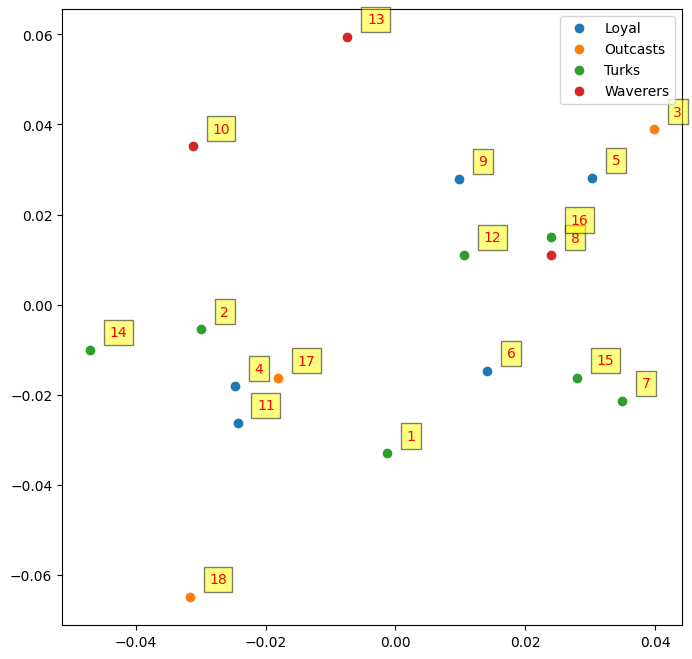

In [7]:
import pandas as pd

avg_X_coin = jnp.mean(X_coin,axis=2)
avg_X_pgd = jnp.mean(X_pgd,axis=2)

names = ["John Bosco", "Gregory", "Basil", "Peter", "Bonaventure", "Berthold", "Mark", "Victor", "Ambrose", "Romauld", "Louis", "Winfrid", "Amand", "Hugh", "Boniface", "Albert", "Elias", "Simplicius"]
numbers = [str(a) for a in np.arange(1,19)]
group = ["Turks", "Turks", "Outcasts", "Loyal", "Loyal", "Loyal", "Turks", "Loyal", "Loyal", "Loyal", "Loyal", "Turks", "Outcasts", "Turks", "Turks", "Turks", "Outcasts", "Outcasts"]
waverers = ["Turks", "Turks", "Outcasts", "Loyal", "Loyal", "Loyal", "Turks", "Waverers", "Loyal", "Waverers", "Loyal", "Turks", "Waverers", "Turks", "Turks", "Turks", "Outcasts", "Outcasts"]

data = pd.DataFrame({"X": avg_X_pgd[:,0], "Y": avg_X_pgd[:,1], "Group": waverers})
groups = data.groupby("Group")
fig = plt.figure(figsize=(8,8), dpi= 100)
for name, group in groups:
    plt.plot(np.asarray(group["X"]), np.asarray(group["Y"]), marker="o", linestyle="", label=name)
plt.legend()
#plt.scatter(avg_X_pgd[:,0],avg_X_pgd[:,1])
for i in range(D):
    plt.text(x=avg_X_pgd[i,0]+0.003,y=avg_X_pgd[i,1]+0.003,s=numbers[i],fontdict=dict(color='red',size=10),bbox=dict(facecolor='yellow',alpha=0.5))

# Plot the results from the random dot product graph

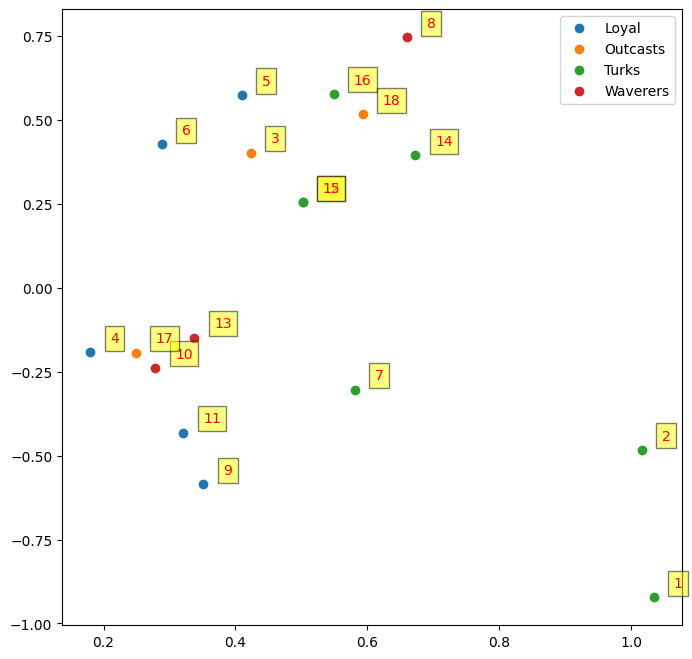

In [8]:
import pandas as pd


names = ["John Bosco", "Gregory", "Basil", "Peter", "Bonaventure", "Berthold", "Mark", "Victor", "Ambrose", "Romauld", "Louis", "Winfrid", "Amand", "Hugh", "Boniface", "Albert", "Elias", "Simplicius"]
numbers = [str(a) for a in np.arange(1,19)]
group = ["Turks", "Turks", "Outcasts", "Loyal", "Loyal", "Loyal", "Turks", "Loyal", "Loyal", "Loyal", "Loyal", "Turks", "Outcasts", "Turks", "Turks", "Turks", "Outcasts", "Outcasts"]
waverers = ["Turks", "Turks", "Outcasts", "Loyal", "Loyal", "Loyal", "Turks", "Waverers", "Loyal", "Waverers", "Loyal", "Turks", "Waverers", "Turks", "Turks", "Turks", "Outcasts", "Outcasts"]

data = pd.DataFrame({"X": x_latent[:,0], "Y": x_latent[:,1], "Group": waverers})
groups = data.groupby("Group")
fig = plt.figure(figsize=(8,8), dpi= 100)
for name, group in groups:
    plt.plot(np.asarray(group["X"]), np.asarray(group["Y"]), marker="o", linestyle="", label=name)
plt.legend()
#plt.scatter(avg_X_pgd[:,0],avg_X_pgd[:,1])
for i in range(D):
    plt.text(x=x_latent[i,0]+0.03,y=x_latent[i,1]+0.03,s=numbers[i],fontdict=dict(color='red',size=10),bbox=dict(facecolor='yellow',alpha=0.5))

And plot the parameter estimates as a function of k:

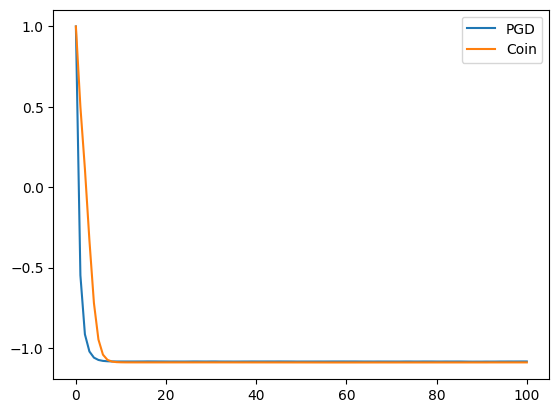

In [9]:
#plt.plot(th_vi, label='VI')
plt.plot(th_pgd, label='PGD')
#plt.xlim([-K/100, K])
#plt.plot(th_pqn, label='PQN')
#plt.plot(th_pmgd, label='PMGD')
#plt.plot(th_soul, label='SOUL')
plt.plot(th_coin, label='Coin')
plt.legend(loc='upper right')

The estimates produced by all five algorithms converge to the same limit after similar transients. To observe more significant differences between the algorithms' outputs, we examine the posterior approximations they return...